### Gradient computation (Backpropagation through time)

(copied from Wataru's notebook)

$$
\begin{align}
\frac{\partial E_t}{\partial\boldsymbol{y}_t}&=\boldsymbol{y}_t-\bar{\boldsymbol{y}}_t \tag{6}\\
\frac{\partial E_t}{\partial\boldsymbol{v}_t}&=\frac{\partial E_t}{\partial\boldsymbol{y}_t}\frac{\partial\boldsymbol{y}_t}{\partial\boldsymbol{v}_t}=\frac{\partial E_t}{\partial\boldsymbol{y}_t}*(1-\boldsymbol{y}_t)*\boldsymbol{y}_t \tag{7}\\
\frac{\partial E_t}{\partial\boldsymbol{c}_t}&=\boldsymbol{W}_{vc}^T\frac{\partial E_t}{\partial\boldsymbol{v}_t}+\boldsymbol{W}_{uc}^T\frac{\partial E_t}{\partial\boldsymbol{u}_{t+1}} \tag{8}\\
\frac{\partial E_t}{\partial\boldsymbol{u}_t}&=\frac{\partial E_t}{\partial\boldsymbol{c}_t}\frac{\partial\boldsymbol{c}_t}{\partial\boldsymbol{u}_t}=\frac{\partial E_t}{\partial\boldsymbol{c}_t}*(1-\boldsymbol{c}_t)*\boldsymbol{c}_t \tag{9}
\end{align}
$$
where $*$ denotes element-wise multiplication. Note that for $y=1/(1+e^{-x})$, $dy/dx=(1-y)*y$.  
Gradient for each parameter is computed as follows.
$$
\begin{aligned}
\frac{\partial E_t}{\partial\boldsymbol{W}_{vc}}&=\frac{\partial E_t}{\partial\boldsymbol{v}_t}\frac{\partial\boldsymbol{v}_t}{\partial\boldsymbol{W}_{vc}}=\frac{\partial E_t}{\partial\boldsymbol{v}_t}\boldsymbol{c}_t^T\\
\frac{\partial E_t}{\partial\boldsymbol{b}_{v}}&=\frac{\partial E_t}{\partial\boldsymbol{v}_t}\frac{\partial\boldsymbol{v}_t}{\partial\boldsymbol{b}_v}=\frac{\partial E_t}{\partial\boldsymbol{v}_t}\\
\frac{\partial E_t}{\partial\boldsymbol{W}_{uc}}&=\frac{\partial E_t}{\partial\boldsymbol{u}_t}\frac{\partial\boldsymbol{u}_t}{\partial\boldsymbol{W}_{uc}}=\frac{\partial E_t}{\partial\boldsymbol{u}_t}\boldsymbol{c}_{t-1}^T\\
\frac{\partial E_t}{\partial\boldsymbol{W}_{ux}}&=\frac{\partial E_t}{\partial\boldsymbol{u}_t}\frac{\partial\boldsymbol{u}_t}{\partial\boldsymbol{W}_{ux}}=\frac{\partial E_t}{\partial\boldsymbol{u}_t}\boldsymbol{x}_t^T\\
\frac{\partial E_t}{\partial\boldsymbol{b}_u}&=\frac{\partial E_t}{\partial\boldsymbol{u}_t}\frac{\partial\boldsymbol{u}_t}{\partial\boldsymbol{b}_u}=\frac{\partial E_t}{\partial\boldsymbol{u}_t}\\
\end{aligned}
$$


In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 120

np.random.seed(0)

from elman import ElmanNetwork, normalize

## 1D Test

In [4]:
# Data to learn
x = np.linspace(0, 4*np.pi, 50)
y = np.sin(x)

normalizedData = normalize(y)

numEpochs = 8000

model = ElmanNetwork(inputDim=1,
                     contextDim=15,
                     outputDim=1,
                     learningRate=.1)

# predict next time step of the sinusoidal sequence
inputArr = normalizedData[:-1].reshape(-1, 1)
targetArr = normalizedData[1:].reshape(-1, 1)
errorArr = np.zeros(numEpochs) # list to store errors

for epoch in range(numEpochs):
    # Context and output
    contextArr, outputArr = model.forwardSequence(inputArr)
    errorArr[epoch]  = model.backwardSequence(inputArr, contextArr, outputArr, targetArr)
    model.updateParameters()
    
model.save('models/1d.npz')

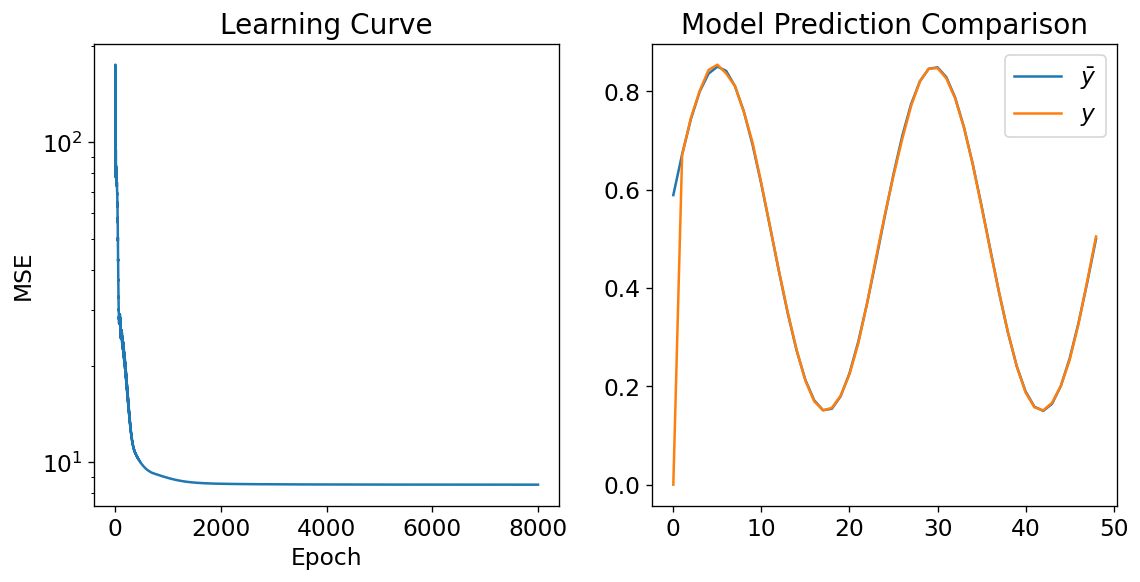

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(11,5))

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1].plot(targetArr, label=r'$ \bar y $')
ax[1].plot(outputArr, label='$ y $')
ax[1].legend()
ax[1].set_title('Model Prediction Comparison')

plt.show()

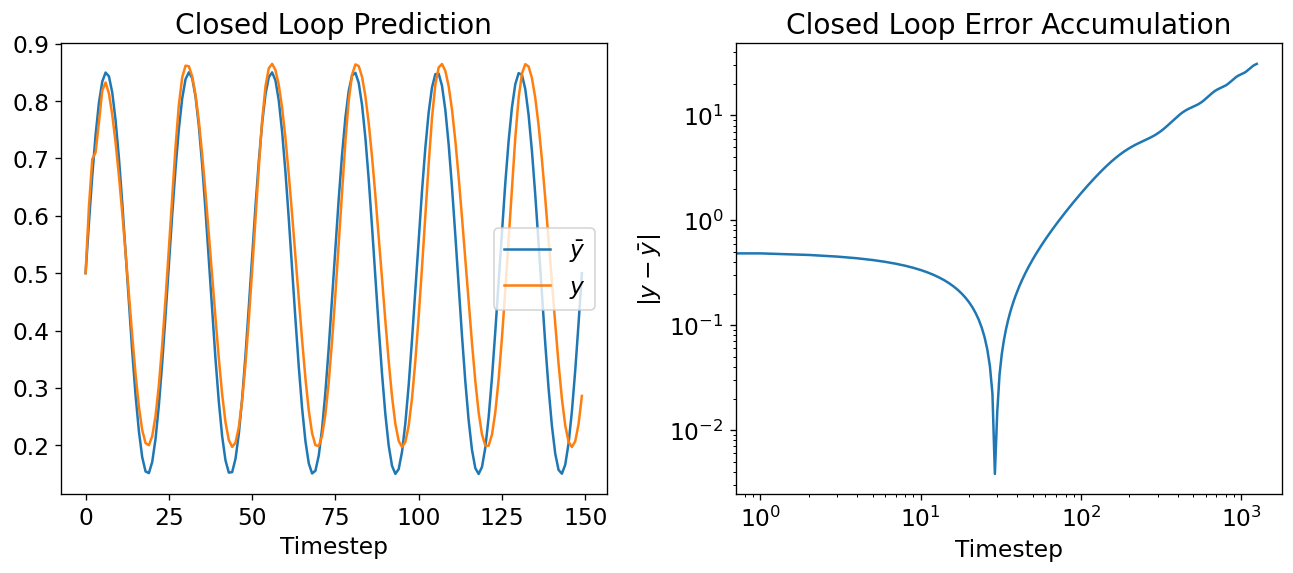

In [294]:
fig, ax = plt.subplots(1, 2, figsize=(11,5))

xArr = np.linspace(0, 12*np.pi, 150)
yArr = normalize(np.sin(xArr))

predictArr = model.predict(yArr[0], predictionSteps=len(yArr)-1)

ax[0].plot(yArr, label=r'$ \bar y $')
ax[0].plot(predictArr, label='$ y $')
ax[0].set_xlabel('Timestep')
ax[0].legend()
ax[0].set_title('Closed Loop Prediction')

xArr = np.linspace(0, 10*np.pi, 1250)
yArr = normalize(np.sin(xArr))

predictArr = model.predict(yArr[0], predictionSteps=len(yArr)-1)

ax[1].plot(np.abs(yArr - xArr))
ax[1].set_xlabel('Timestep')
ax[1].set_ylabel(r'$| y - \bar y |$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Closed Loop Error Accumulation')
#ax[1].plot(targetArr, label='Target')
#ax[1].plot(outputArr, label='Output')

fig.tight_layout()
plt.show()

## 2D Test

In [295]:
# Data to learn
x = np.linspace(0, 4*np.pi, 50)
y = np.sin(x)
z = np.cos(x)

normalizedY = normalize(y)
normalizedZ = normalize(z)

numEpochs = 8000

model = ElmanNetwork(inputDim=2,
                     contextDim=15,
                     outputDim=2,
                     learningRate=.1)

inputArr = np.array(list(zip(normalizedY, normalizedZ)))[:-1]
targetArr = np.array(list(zip(normalizedY, normalizedZ)))[1:]
errorArr = np.zeros(numEpochs) # list to store errors

for epoch in range(numEpochs):
    # Context and output
    contextArr, outputArr = model.forwardSequence(inputArr)
    errorArr[epoch]  = model.backwardSequence(inputArr, contextArr, outputArr, targetArr)
    model.updateParameters()
    
model.save('models/2d.npz')

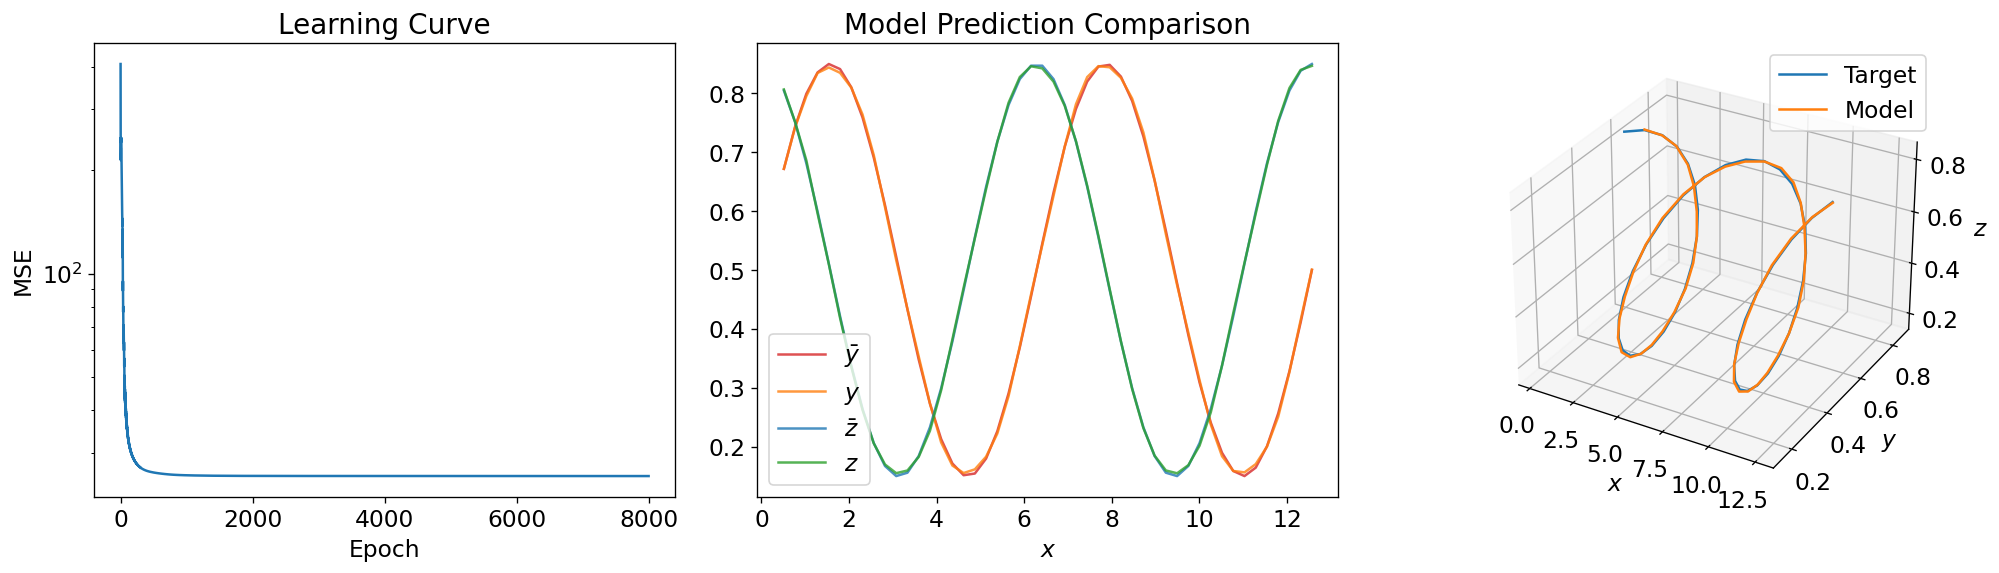

In [304]:
fig = plt.figure(figsize=(17,5))

ax = [None, None, None]
ax[0] = fig.add_subplot(1, 3, 1)

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1] = fig.add_subplot(1, 3, 2)

ax[1].plot(x[2:], targetArr[1:,0], alpha=.8, c='tab:red', label=r'$ \bar y $')
ax[1].plot(x[2:], outputArr[1:,0], alpha=.8, c='tab:orange', label='$ y $')
ax[1].plot(x[2:], targetArr[1:,1], alpha=.8, c='tab:blue', label=r'$ \bar z $')
ax[1].plot(x[2:], outputArr[1:,1], alpha=.8, c='tab:green', label='$ z $')
ax[1].legend()
ax[1].set_xlabel('$x$')
ax[1].set_title('Model Prediction Comparison')

ax[2] = fig.add_subplot(1, 3, 3, projection='3d')

ax[2].plot(x[1:], normalizedY[1:], normalizedZ[1:], label='Target')
ax[2].plot(x[2:], outputArr[1:,0], outputArr[1:,1], label='Model')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$y$')
ax[2].set_zlabel('$z$')
ax[2].legend()

fig.tight_layout()

plt.show()